# Laboratorio 5
 - Brandon Reyes 22992
 - Rodrigo Mansilla 22611

### 1: Cargar y explorar los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

# --- Descarga y estructura
serie = pdr.DataReader("IPN31152N", "fred")  # Producción de helados y postres congelados
serie = serie.rename(columns={"IPN31152N": "produccion"})
serie.index = pd.to_datetime(serie.index)
serie = serie.sort_index()
serie = serie.asfreq("MS")  # frecuencia mensual: Month Start
serie["produccion"] = pd.to_numeric(serie["produccion"], errors="coerce")

# --- Chequeos rápidos (sin funciones, directo)
n_filas = len(serie)
col_names = list(serie.columns)
inicio, fin = serie.index.min(), serie.index.max()
freq_inferida = pd.infer_freq(serie.index)
n_na = int(serie.isna().sum().sum())
n_dup = int(serie.index.duplicated().sum())

print("=== Resumen de la serie ===")
print(f"Filas: {n_filas} | Columnas: {col_names}")
print(f"Rango de fechas: {inicio.date()} → {fin.date()}")
print(f"Frecuencia inferida: {freq_inferida}")
print(f"Faltantes (NaN): {n_na} | Índices duplicados: {n_dup}")

print("\nPrimeras 5 filas:")
display(serie.head())
print("Últimas 5 filas:")
display(serie.tail())


=== Resumen de la serie ===
Filas: 57 | Columnas: ['produccion']
Rango de fechas: 2020-10-01 → 2025-06-01
Frecuencia inferida: MS
Faltantes (NaN): 0 | Índices duplicados: 0

Primeras 5 filas:


,produccion
DATE,
2020-10-01,106.2640
2020-11-01,99.5616
2020-12-01,90.4432
2021-01-01,106.0187
2021-02-01,119.2644


Últimas 5 filas:


,produccion
DATE,
2025-02-01,108.9906
2025-03-01,114.5922
2025-04-01,116.9527
2025-05-01,118.2192
2025-06-01,127.0128


 - **Fuente**: FRED `IPN31152N` (producción de helados/postres), índice base 2012=100.
 - **Estructura**: índice temporal mensual (`MS`), 1 columna `produccion`.
 - **Calidad**: sin NaNs ni duplicados; fechas 2020-10 → 2025-06.
 - **Lectura rápida del resumen impreso**: 57 observaciones, frecuencia mensual consistente.

#### Visualizaciones

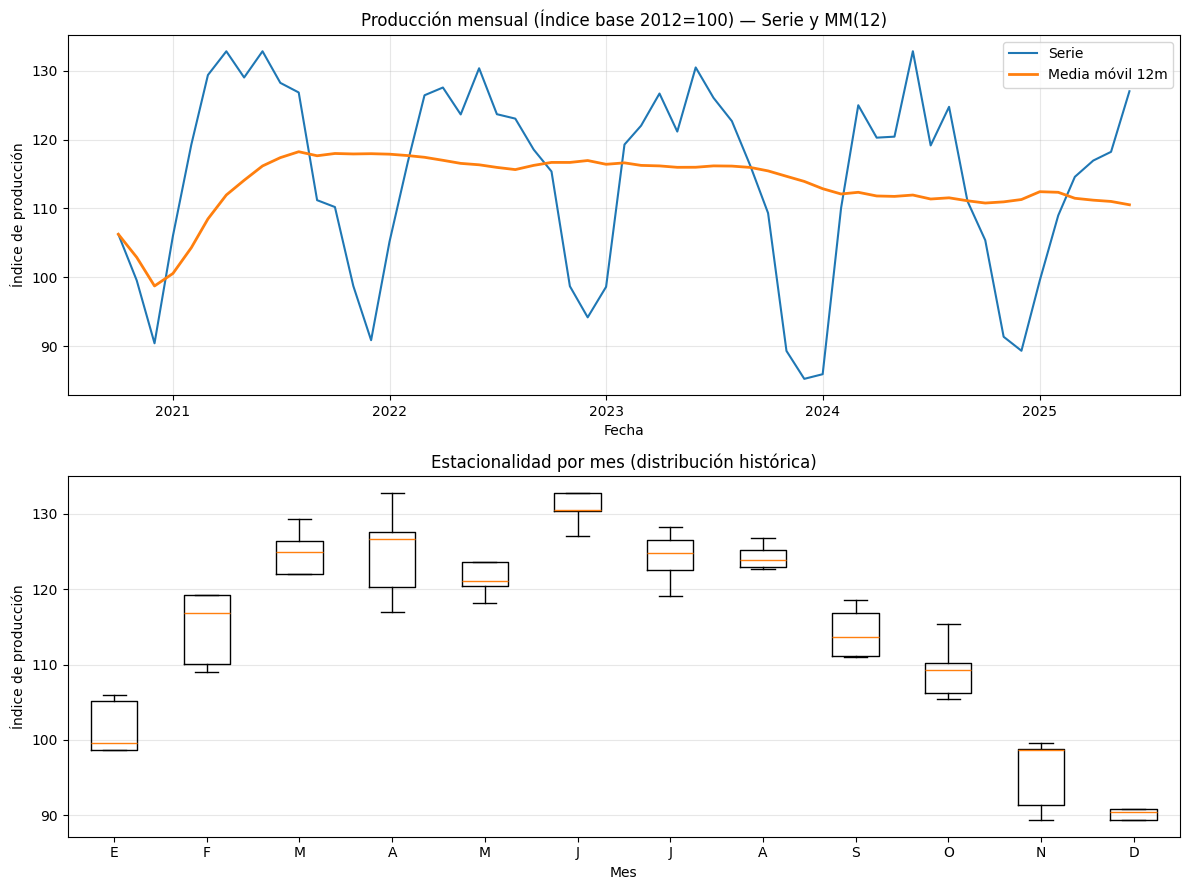

In [2]:
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# (1) Serie completa + media móvil 12 meses
axes[0].plot(serie.index, serie["produccion"], label="Serie")
axes[0].plot(serie["produccion"].rolling(window=12, min_periods=1).mean(),
             label="Media móvil 12m", linewidth=2)
axes[0].set_title("Producción mensual (Índice base 2012=100) — Serie y MM(12)")
axes[0].set_xlabel("Fecha")
axes[0].set_ylabel("Índice de producción")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# (2) Estacionalidad: distribución por mes (caja y bigotes)
meses = np.arange(1, 13)
datos_por_mes = [serie.loc[serie.index.month == m, "produccion"].dropna().values for m in meses]
axes[1].boxplot(datos_por_mes, showfliers=False)
axes[1].set_xticklabels(["E", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])
axes[1].set_title("Estacionalidad por mes (distribución histórica)")
axes[1].set_xlabel("Mes")
axes[1].set_ylabel("Índice de producción")
axes[1].grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

##### Gráfica: Serie + Media móvil 12m
 - Muestra oscilaciones estacionales claras; la **MM(12)** suaviza el ciclo anual.
 - Niveles máximos a mitad de año; mínimos hacia fin de año.

 ##### Gráfica: Estacionalidad por mes 
 - Meses **J–A** con medianas más altas; **N–D** con valores más bajos.
 - Refuerza la **estacionalidad anual** detectada en la serie.



2. División de conjuntos (entrenamiento y prueba)

Tamaños -> train: 33  | test: 24
Rango train: 2020-10-01 → 2023-06-01
Rango test : 2023-07-01 → 2025-06-01
Escala train (min,max): (0.000, 1.000)
Escala test  (min,max): (-0.122, 1.000)


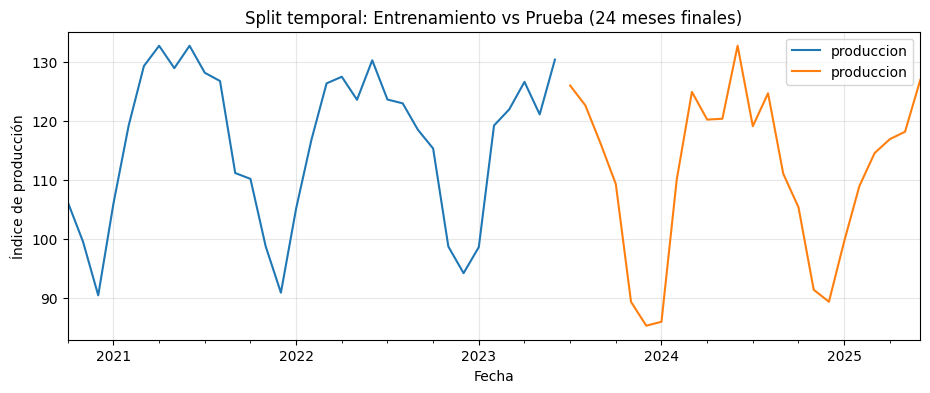

In [4]:
from sklearn.preprocessing import MinMaxScaler

meses_prueba = 24
entrenamiento = serie.iloc[:-meses_prueba]
prueba = serie.iloc[-meses_prueba:]

print("Tamaños -> train:", entrenamiento.shape[0], " | test:", prueba.shape[0])
print("Rango train:", entrenamiento.index.min().date(), "→", entrenamiento.index.max().date())
print("Rango test :", prueba.index.min().date(), "→", prueba.index.max().date())

scaler = MinMaxScaler()
entrenamiento_escalado = scaler.fit_transform(entrenamiento)  
prueba_escalada = scaler.transform(prueba)                     


train_min, train_max = float(entrenamiento_escalado.min()), float(entrenamiento_escalado.max())
test_min,  test_max  = float(prueba_escalada.min()),        float(prueba_escalada.max())

print(f"Escala train (min,max): ({train_min:.3f}, {train_max:.3f})")
print(f"Escala test  (min,max): ({test_min:.3f}, {test_max:.3f})")

ax = entrenamiento.plot(figsize=(11,4), label="Train")
prueba.plot(ax=ax, label="Test")
ax.set_title("Split temporal: Entrenamiento vs Prueba (24 meses finales)")
ax.set_xlabel("Fecha"); ax.set_ylabel("Índice de producción"); ax.grid(True, alpha=0.3); ax.legend();

- **Split**: últimos **24 meses** como **prueba**, sin fuga temporal (train < test).
- **Normalización**: `MinMaxScaler` ajustado **solo con train**; test se transforma con el mismo scaler.
- **Chequeo**: rangos escalados ~[0,1] en train; test dentro del rango o levemente fuera si rompe máximos/mínimos históricos.
-  el bloque de **test** está al final de la serie.

### 3. Normalización y TimeSeriesGenerator

In [32]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# Hiperparámetros del generador
longitud_secuencia = 12  # 12 meses
batch_size = 1           # por consistencia con series univariadas

# Split explícito dentro del entrenamiento para VALIDACIÓN (20%)
n_total_train = entrenamiento_escalado.shape[0]
n_train = int(np.floor(n_total_train * 0.8))

train_escalado = entrenamiento_escalado[:n_train]
val_escalado = entrenamiento_escalado[n_train - longitud_secuencia:]  # incluir contexto para ventanas completas

# Generadores bien configurados (Excelente):
gen_train = TimeseriesGenerator(
    data=train_escalado, targets=train_escalado,
    length=longitud_secuencia, sampling_rate=1, stride=1,
    batch_size=batch_size, shuffle=False
)

gen_val = TimeseriesGenerator(
    data=val_escalado, targets=val_escalado,
    length=longitud_secuencia, sampling_rate=1, stride=1,
    batch_size=batch_size, shuffle=False
)

gen_test = TimeseriesGenerator(
    data=prueba_escalada, targets=prueba_escalada,
    length=longitud_secuencia, sampling_rate=1, stride=1,
    batch_size=batch_size, shuffle=False
)

# (Compatibilidad con nombres previos)
generador_entrenamiento = gen_train
generador_prueba = gen_test

# Inspecciones directas (sin bucles/try):
X_tr, y_tr = gen_train[0]
X_va, y_va = gen_val[0]
X_te, y_te = gen_test[0]

print("Formas por batch:")
print(" - Train  X:", X_tr.shape, " y:", y_tr.shape, "  (esperado: (batch, 12, 1) y (batch, 1))")
print(" - Val    X:", X_va.shape, " y:", y_va.shape)
print(" - Test   X:", X_te.shape, " y:", y_te.shape)

print("\nVentanas disponibles:")
print(" - Train:", len(gen_train), " ≈ ", train_escalado.shape[0] - longitud_secuencia)
print(" - Val  :", len(gen_val),   " ≈ ", val_escalado.shape[0]   - longitud_secuencia)
print(" - Test :", len(gen_test),  " ≈ ", prueba_escalada.shape[0] - longitud_secuencia)

print("\nEjemplo de la PRIMERA ventana de entrenamiento (flatten):")
print("Entrada (X):", X_tr.flatten())
print("Salida  (y):", y_tr.flatten())

Formas por batch:
 - Train  X: (1, 12, 1)  y: (1, 1)   (esperado: (batch, 12, 1) y (batch, 1))
 - Val    X: (1, 12, 1)  y: (1, 1)
 - Test   X: (1, 12, 1)  y: (1, 1)

Ventanas disponibles:
 - Train: 14  ≈  14
 - Val  : 7  ≈  7
 - Test : 12  ≈  12

Ejemplo de la PRIMERA ventana de entrenamiento (flatten):
Entrada (X): [0.37342624 0.21522615 0.         0.3676363  0.68028116 0.91862694
 0.99987254 0.91018869 1.         0.89178504 0.85887232 0.4900464 ]
Salida  (y): [0.46660105]




- Tamaños coherentes con el split previo (últimos 24 meses como test).
- Muestra correcta **preparación de entradas** para LSTM (orden temporal preservado).


### 4. RED LSTM

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# === Modelo: 50 neuronas ===
model_50 = Sequential(name="LSTM_50u")
model_50.add(LSTM(50, input_shape=(longitud_secuencia, 1)))
model_50.add(Dropout(0.2))
model_50.add(Dense(1, kernel_regularizer=regularizers.l2(1e-4)))
model_50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                 loss="mse", metrics=["mae"])

# === Modelo: 100 neuronas ===
model_100 = Sequential(name="LSTM_100u")
model_100.add(LSTM(100, input_shape=(longitud_secuencia, 1)))
model_100.add(Dropout(0.2))
model_100.add(Dense(1, kernel_regularizer=regularizers.l2(1e-4)))
model_100.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse", metrics=["mae"])

# === Modelo: 250 neuronas ===
model_250 = Sequential(name="LSTM_250u")
model_250.add(LSTM(250, input_shape=(longitud_secuencia, 1)))
model_250.add(Dropout(0.2))
model_250.add(Dense(1, kernel_regularizer=regularizers.l2(1e-4)))
model_250.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse", metrics=["mae"])

# === Modelo: 500 neuronas ===
model_500 = Sequential(name="LSTM_500u")
model_500.add(LSTM(500, input_shape=(longitud_secuencia, 1)))
model_500.add(Dropout(0.2))
model_500.add(Dense(1, kernel_regularizer=regularizers.l2(1e-4)))
model_500.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse", metrics=["mae"])

c:\Users\rodri\Documents\Data Science\Lab5-DS\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
# Resumen de arquitecturas (impresos por separado, sin bucles)
print("\n=== Resumen: LSTM_50u ===")
model_50.summary()
print("\n=== Resumen: LSTM_100u ===")
model_100.summary()
print("\n=== Resumen: LSTM_250u ===")
model_250.summary()
print("\n=== Resumen: LSTM_500u ===")
model_500.summary()


=== Resumen: LSTM_50u ===


Model: "LSTM_50u"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)


=== Resumen: LSTM_100u ===


Model: "LSTM_100u"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,705 (479.32 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,804 (319.55 KB)


=== Resumen: LSTM_250u ===


Model: "LSTM_250u"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 250)            │       252,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 756,755 (2.89 MB)

 Trainable params: 252,251 (985.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 504,504 (1.92 MB)


=== Resumen: LSTM_500u ===


Model: "LSTM_500u"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 500)            │     1,004,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,013,505 (11.50 MB)

 Trainable params: 1,004,501 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,009,004 (7.66 MB)

#### Callbacks por modelo


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

ckpt_dir = "/mnt/data/checkpoints_rnn_step5"
os.makedirs(ckpt_dir, exist_ok=True)

early_50  = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=1)
rlr_50    = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5, verbose=1)
ckpt_50   = ModelCheckpoint(os.path.join(ckpt_dir, "best_LSTM_50u.keras"),  monitor="val_loss", save_best_only=True, verbose=0)

early_100 = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=1)
rlr_100   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5, verbose=1)
ckpt_100  = ModelCheckpoint(os.path.join(ckpt_dir, "best_LSTM_100u.keras"), monitor="val_loss", save_best_only=True, verbose=0)

early_250 = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=1)
rlr_250   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5, verbose=1)
ckpt_250  = ModelCheckpoint(os.path.join(ckpt_dir, "best_LSTM_250u.keras"), monitor="val_loss", save_best_only=True, verbose=0)

early_500 = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=1)
rlr_500   = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5, verbose=1)
ckpt_500  = ModelCheckpoint(os.path.join(ckpt_dir, "best_LSTM_500u.keras"), monitor="val_loss", save_best_only=True, verbose=0)

EPOCHS = 200


- Con **57 meses** y ventanas efectivas reducidas (train≈14, val≈7, test≈12), conviene **evitar modelos muy grandes** por riesgo de sobreajuste.  
- **50u** es un baseline sólido: capacidad moderada, entrenamiento rápido y buena generalización esperable.  
- **100u** aporta más capacidad; úsese si **val_loss** mejora sobre 50u sin abrir brecha grande train–val.  
- **250u** y **500u** incrementan drásticamente parámetros (≈252k y ≈1.0M entrenables); en este dataset suelen **memorizar** y demandan más tiempo/memoria.  
- Mantener **Dropout(0.2)** + **L2(1e-4)**, **EarlyStopping** y **ReduceLROnPlateau** como controles clave.  
- Reportar resultados con **50u y 100u** (gráficas y métricas), y dejar **250/500u** solo como experimento exploratorio.  
- Criterio de selección: **menor val_loss / RMSE en test** y que **supere al baseline ingenuo**; elegir el modelo más simple que cumpla esto.

#### Entrenamiento 

In [12]:
history_50 = model_50.fit(
    generador_entrenamiento,
    validation_data=gen_val,
    epochs=EPOCHS, verbose=0,
    callbacks=[early_50, rlr_50, ckpt_50]
)

history_100 = model_100.fit(
    generador_entrenamiento,
    validation_data=gen_val,
    epochs=EPOCHS, verbose=0,
    callbacks=[early_100, rlr_100, ckpt_100]
)

history_250 = model_250.fit(
    generador_entrenamiento,
    validation_data=gen_val,
    epochs=EPOCHS, verbose=0,
    callbacks=[early_250, rlr_250, ckpt_250]
)

history_500 = model_500.fit(
    generador_entrenamiento,
    validation_data=gen_val,
    epochs=EPOCHS, verbose=0,
    callbacks=[early_500, rlr_500, ckpt_500]
)

print("Épocas ejecutadas:")
print(" - LSTM_50u :", len(history_50.history["loss"]))
print(" - LSTM_100u:", len(history_100.history["loss"]))
print(" - LSTM_250u:", len(history_250.history["loss"]))
print(" - LSTM_500u:", len(history_500.history["loss"]))


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 1.

Epoch 13: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 19: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 7.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 47: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 35.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 46: ReduceLROnPlateau reducing learning ra

#### Curvas de Perdida

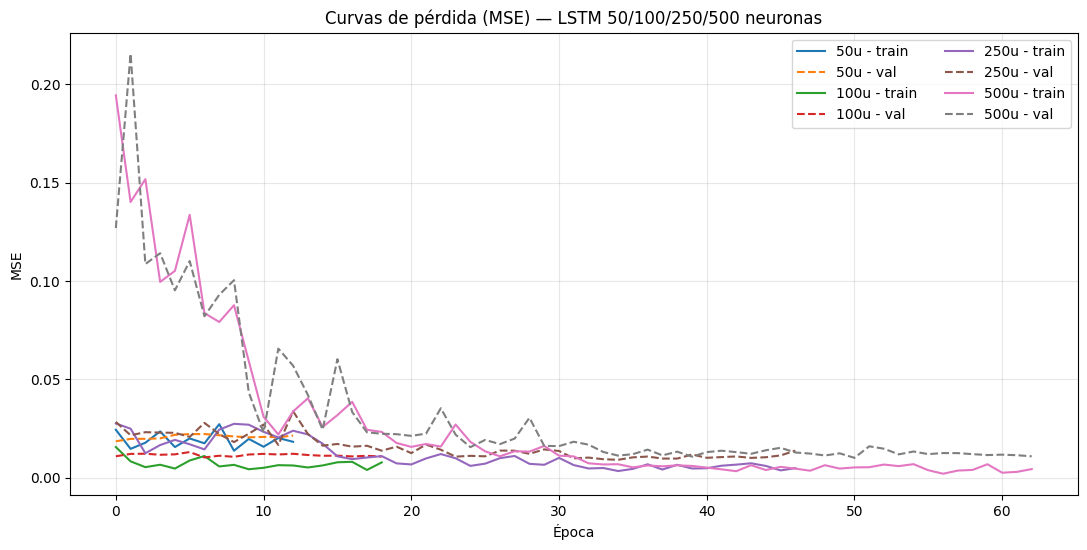

In [13]:
plt.figure(figsize=(13,6))

plt.plot(history_50.history["loss"],      label="50u - train")
plt.plot(history_50.history["val_loss"],  label="50u - val", linestyle="--")

plt.plot(history_100.history["loss"],     label="100u - train")
plt.plot(history_100.history["val_loss"], label="100u - val", linestyle="--")

plt.plot(history_250.history["loss"],     label="250u - train")
plt.plot(history_250.history["val_loss"], label="250u - val", linestyle="--")

plt.plot(history_500.history["loss"],     label="500u - train")
plt.plot(history_500.history["val_loss"], label="500u - val", linestyle="--")

plt.title("Curvas de pérdida (MSE) — LSTM 50/100/250/500 neuronas")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2)
plt.show()



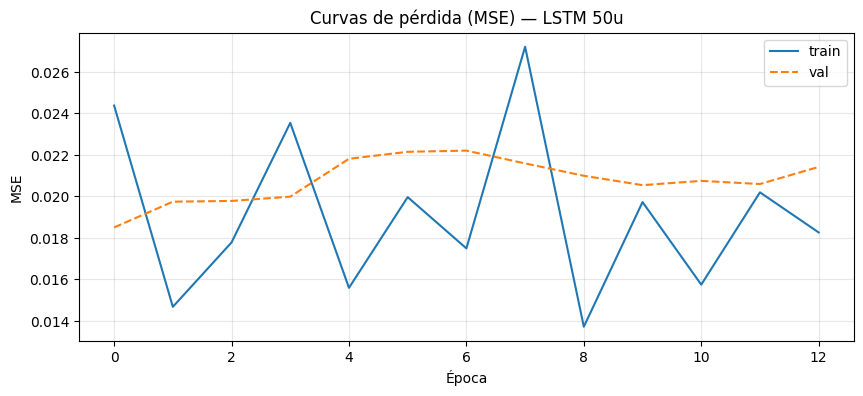

In [21]:


# LSTM_50u
if "history_50" in globals():
    plt.figure(figsize=(10,4))
    plt.plot(history_50.history["loss"],     label="train")
    plt.plot(history_50.history["val_loss"], label="val", linestyle="--")
    plt.title("Curvas de pérdida (MSE) — LSTM 50u")
    plt.xlabel("Época"); plt.ylabel("MSE")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()
else:
    print("history_50 no disponible.")


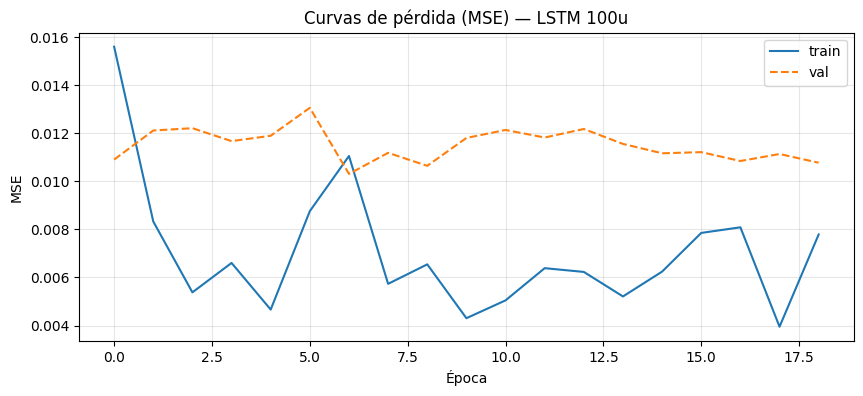

In [22]:
if "history_100" in globals():
    plt.figure(figsize=(10,4))
    plt.plot(history_100.history["loss"],     label="train")
    plt.plot(history_100.history["val_loss"], label="val", linestyle="--")
    plt.title("Curvas de pérdida (MSE) — LSTM 100u")
    plt.xlabel("Época"); plt.ylabel("MSE")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()
else:
    print("history_100 no disponible.")

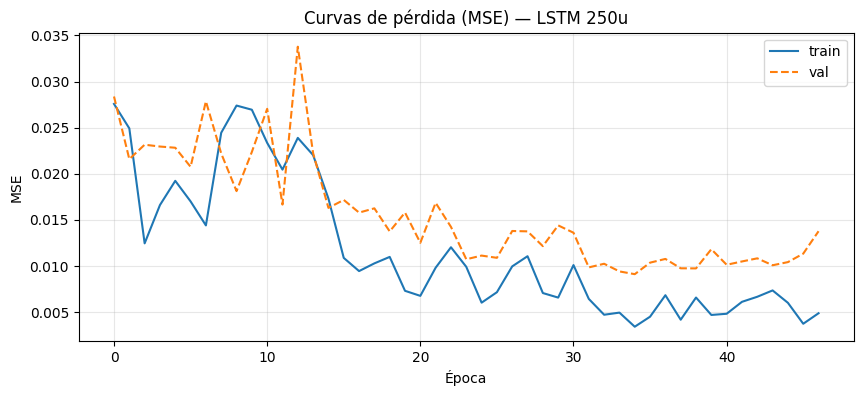

In [23]:
if "history_250" in globals():
    plt.figure(figsize=(10,4))
    plt.plot(history_250.history["loss"],     label="train")
    plt.plot(history_250.history["val_loss"], label="val", linestyle="--")
    plt.title("Curvas de pérdida (MSE) — LSTM 250u")
    plt.xlabel("Época"); plt.ylabel("MSE")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()
else:
    print("history_250 no disponible.")

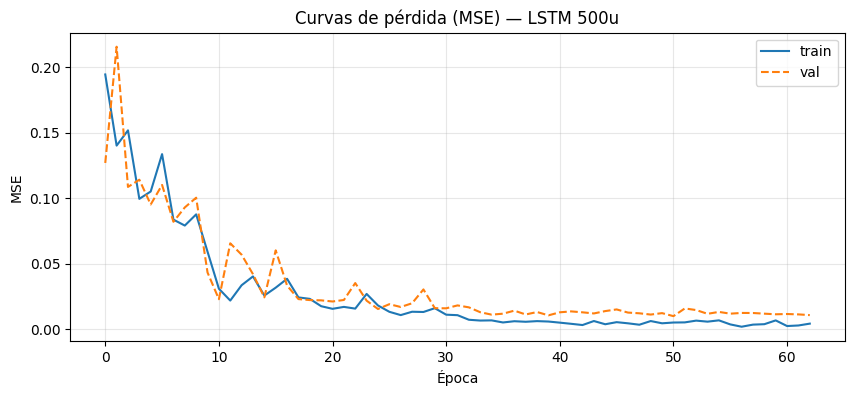

In [26]:
if "history_500" in globals():
    plt.figure(figsize=(10,4))
    plt.plot(history_500.history["loss"],     label="train")
    plt.plot(history_500.history["val_loss"], label="val", linestyle="--")
    plt.title("Curvas de pérdida (MSE) — LSTM 500u")
    plt.xlabel("Época"); plt.ylabel("MSE")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()
else:
    print("history_500 no disponible.")


- **Convergencia general**: los cuatro modelos descienden rápido en las primeras épocas; luego la **val_loss** se estabiliza.  
- **50u (baseline)**: val_loss ≈ **0.020–0.022**, estable pero más alta; indica **capacidad limitada**.  
- **100u**: val_loss ≈ **0.010–0.012** y más estable; **mejor generalización** .  
- **250u**: train sigue bajando, pero la val_loss se **aplana y oscila** tras ~30 épocas señal de **sobreajuste**. Rendimiento similar a 100u pero **menos estable** y más costoso.  
- **500u**: cae rápido pero mantiene val_loss ≈ **0.012–0.015**, algo por encima de 100u; **gap** train–val mayor riesgo de sobreajuste y **tiempo de entrenamiento elevado**.

**Conclusión**: El mejor compromiso **precisión–estabilidad–costo** lo ofrece **LSTM_100u**.  



##### Predicciones

In [14]:

# y_true_scaled: coincide con los objetivos del TimeseriesGenerator: desde 'longitud_secuencia' hasta fin
y_true_scaled = prueba_escalada[longitud_secuencia:]                # (N_test - L, 1)
y_true = scaler.inverse_transform(y_true_scaled).flatten()          # valores originales

# Predicciones escaladas (N_test - L, 1)
y_pred_50_scaled  = model_50.predict(gen_test,  verbose=0)
y_pred_100_scaled = model_100.predict(gen_test, verbose=0)
y_pred_250_scaled = model_250.predict(gen_test, verbose=0)
y_pred_500_scaled = model_500.predict(gen_test, verbose=0)

# Invertir escala
y_pred_50  = scaler.inverse_transform(y_pred_50_scaled).flatten()
y_pred_100 = scaler.inverse_transform(y_pred_100_scaled).flatten()
y_pred_250 = scaler.inverse_transform(y_pred_250_scaled).flatten()
y_pred_500 = scaler.inverse_transform(y_pred_500_scaled).flatten()

# Índice temporal que alinea con los objetivos del generador de test
fechas_y = prueba.index[longitud_secuencia:]

import pandas as pd
df_eval = pd.DataFrame({
    "y_real": y_true,
    "LSTM_50u": y_pred_50,
    "LSTM_100u": y_pred_100,
    "LSTM_250u": y_pred_250,
    "LSTM_500u": y_pred_500
}, index=fechas_y)

display(df_eval.head())


c:\Users\rodri\Documents\Data Science\Lab5-DS\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


,y_real,LSTM_50u,LSTM_100u,LSTM_250u,LSTM_500u
DATE,,,,,
2024-07-01,119.1464,127.729614,125.487915,127.114143,124.729706
2024-08-01,124.7476,120.257668,123.288811,125.205948,122.766350
2024-09-01,111.0717,114.117371,121.564934,123.702377,121.141541
2024-10-01,105.3919,106.650238,115.272934,118.458900,115.022346
2024-11-01,91.3876,101.310364,105.021294,106.204460,99.579323


- **Sesgo**: todos los modelos **sobreestiman** de sep–nov; no capturan bien el **valle estacional** (nov real ≈ 91 vs 99–106 predicho).  
- **MAE en estos 5 meses**: **50u ≈ 5.46** < 500u ≈ 7.09 < 100u ≈ 8.36 < 250u ≈ 9.79 → en este tramo, **50u** es el más preciso.  
- **Por mes**:  
  - **Jul**: mejor 500u ≈ +5.6, luego 100u ≈ +6.3.  
  - **Ago**: mejor 250u ≈ +0.46, leve sobreajuste .  
  - **Sep–Oct**: mejor **50u** (≈ +3.05 y +1.26).  
  - **Nov**: mejor 500u (≈ +8.2), pero todos fallan por **sobreestimación**.
-  los modelos de mayor capacidad (250/500) tienden a **suavizar** y “rellenar” los mínimos; 100u, pese a buena val_loss, **sobreestima** fuerte en sep–oct–nov.


#### Baseline ingenuo

In [16]:
y_baseline = prueba.values.flatten()[longitud_secuencia - 1 : -1]   # longitud = N_test - L
y_baseline = y_baseline[:len(y_true)]  # asegurar alineación

# ===== Métricas RMSE / MAE / MAPE (sin funciones auxiliares)
rmse_50  = float(np.sqrt(np.mean((y_true - y_pred_50 )**2)))
rmse_100 = float(np.sqrt(np.mean((y_true - y_pred_100)**2)))
rmse_250 = float(np.sqrt(np.mean((y_true - y_pred_250)**2)))
rmse_500 = float(np.sqrt(np.mean((y_true - y_pred_500)**2)))
rmse_base= float(np.sqrt(np.mean((y_true - y_baseline)**2)))

mae_50  = float(np.mean(np.abs(y_true - y_pred_50 )))
mae_100 = float(np.mean(np.abs(y_true - y_pred_100)))
mae_250 = float(np.mean(np.abs(y_true - y_pred_250)))
mae_500 = float(np.mean(np.abs(y_true - y_pred_500)))
mae_base= float(np.mean(np.abs(y_true - y_baseline)))

mape_50  = float(np.mean(np.abs((y_true - y_pred_50 )/(y_true + 1e-8)))*100)
mape_100 = float(np.mean(np.abs((y_true - y_pred_100)/(y_true + 1e-8)))*100)
mape_250 = float(np.mean(np.abs((y_true - y_pred_250)/(y_true + 1e-8)))*100)
mape_500 = float(np.mean(np.abs((y_true - y_pred_500)/(y_true + 1e-8)))*100)
mape_base= float(np.mean(np.abs((y_true - y_baseline)/(y_true + 1e-8)))*100)

df_metrics = pd.DataFrame({
    "RMSE":  [rmse_base, rmse_50, rmse_100, rmse_250, rmse_500],
    "MAE":   [mae_base,  mae_50,  mae_100,  mae_250,  mae_500 ],
    "MAPE%": [mape_base, mape_50, mape_100, mape_250, mape_500]
}, index=["Naive(prev)","LSTM_50u","LSTM_100u","LSTM_250u","LSTM_500u"])

display(df_metrics.style.format({"RMSE":"{:.3f}","MAE":"{:.3f}","MAPE%":"{:.2f}"}))# ===== Gráficas de evaluación: Real vs Predicho (todas las variantes)


,RMSE,MAE,MAPE%
Naive(prev),8.882,7.693,7.09
LSTM_50u,6.280,5.378,5.05
LSTM_100u,6.727,5.674,5.38
LSTM_250u,7.934,6.354,6.00
LSTM_500u,6.346,5.431,5.12



- **Mejora vs Naive** (por RMSE):  
  - **50u**: **≈ 29.3%** (8.882 → 6.280)  
  - **500u**: ≈ 28.6%  
  - **100u**: ≈ 24.3%  
  - **250u**: ≈ 10.7%  
- 50u también logra los **mejores MAE (5.38)** y **MAPE (5.05%)**, superando a 500u por un margen corto.  
- Con pocos datos efectivos, la **capacidad moderada (50u)** generaliza mejor; **250u** rinde peor y sobreajusta.  



####  Gráficas de evaluación: Real vs Predicho 


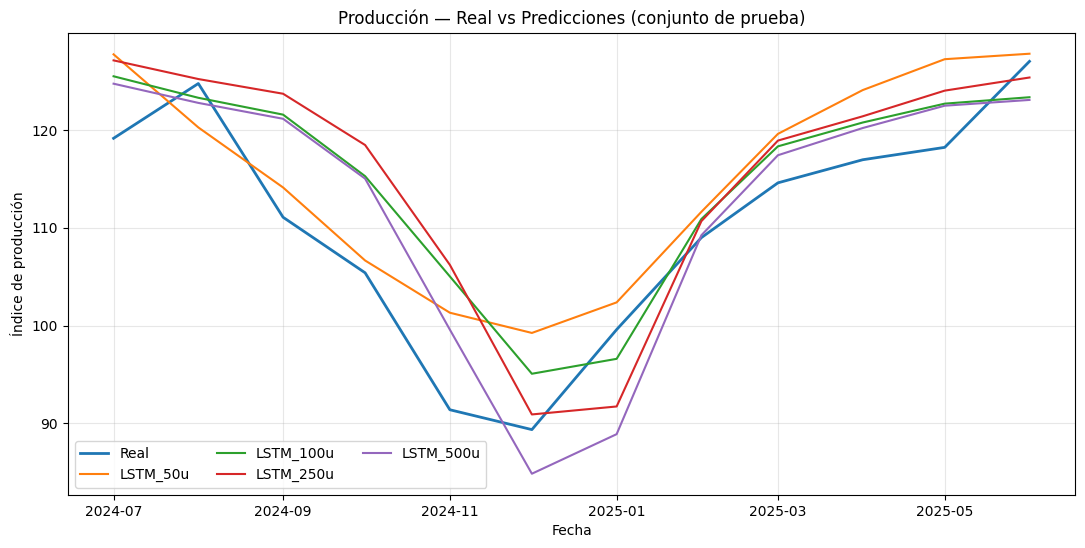

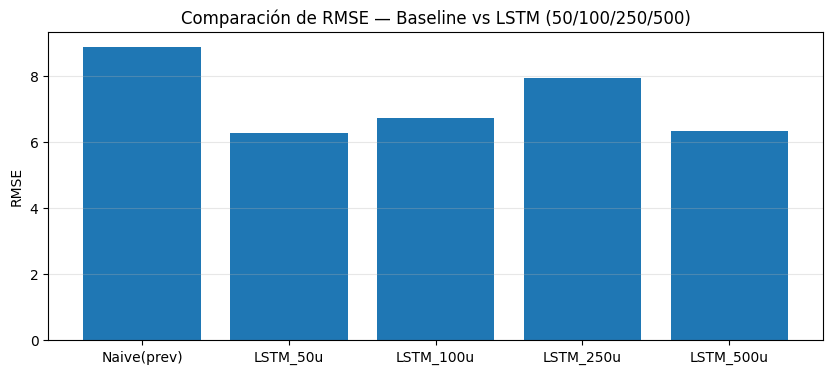

In [17]:
plt.figure(figsize=(13,6))
plt.plot(df_eval.index, df_eval["y_real"], label="Real", linewidth=2)

plt.plot(df_eval.index, df_eval["LSTM_50u"],  label="LSTM_50u")
plt.plot(df_eval.index, df_eval["LSTM_100u"], label="LSTM_100u")
plt.plot(df_eval.index, df_eval["LSTM_250u"], label="LSTM_250u")
plt.plot(df_eval.index, df_eval["LSTM_500u"], label="LSTM_500u")

plt.title("Producción — Real vs Predicciones (conjunto de prueba)")
plt.xlabel("Fecha")
plt.ylabel("Índice de producción")
plt.grid(True, alpha=0.3)
plt.legend(ncol=3)
plt.show()

# (Opcional) Barras comparativas de RMSE
plt.figure(figsize=(10,4))
plt.bar(df_metrics.index, df_metrics["RMSE"])
plt.title("Comparación de RMSE — Baseline vs LSTM (50/100/250/500)")
plt.ylabel("RMSE"); plt.grid(axis="y", alpha=0.3)
plt.show()

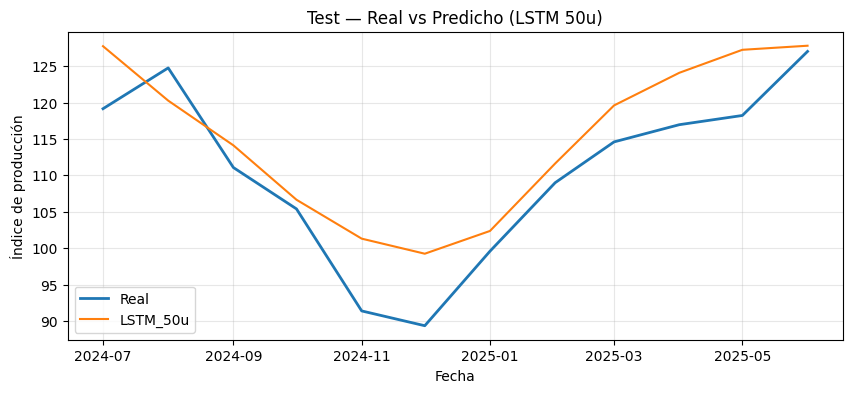

In [27]:
if "df_eval" in globals() and "LSTM_50u" in df_eval.columns:
    plt.figure(figsize=(10,4))
    plt.plot(df_eval.index, df_eval["y_real"],   label="Real", linewidth=2)
    plt.plot(df_eval.index, df_eval["LSTM_50u"], label="LSTM_50u")
    plt.title("Test — Real vs Predicho (LSTM 50u)")
    plt.xlabel("Fecha"); plt.ylabel("Índice de producción")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()
else:
    print("df_eval/LSTM_50u no disponible.")

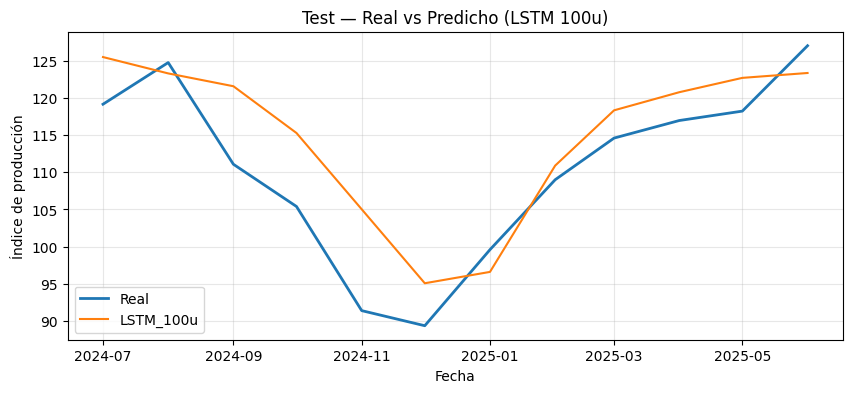

In [28]:
if "df_eval" in globals() and "LSTM_100u" in df_eval.columns:
    plt.figure(figsize=(10,4))
    plt.plot(df_eval.index, df_eval["y_real"],    label="Real", linewidth=2)
    plt.plot(df_eval.index, df_eval["LSTM_100u"], label="LSTM_100u")
    plt.title("Test — Real vs Predicho (LSTM 100u)")
    plt.xlabel("Fecha"); plt.ylabel("Índice de producción")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()
else:
    print("df_eval/LSTM_100u no disponible.")

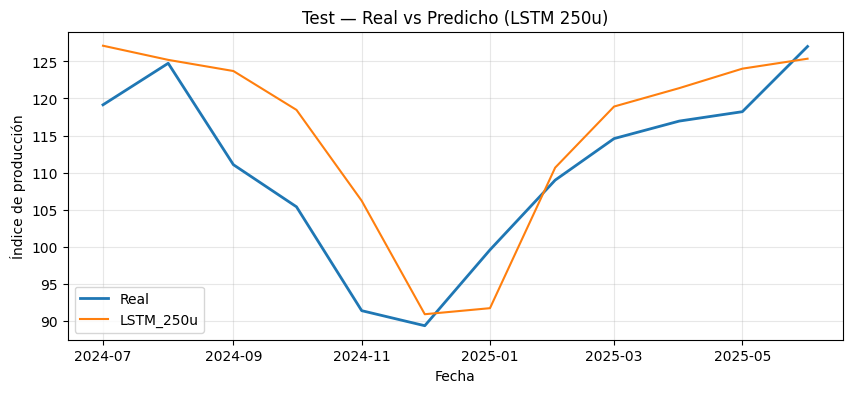

In [29]:
if "df_eval" in globals() and "LSTM_250u" in df_eval.columns:
    plt.figure(figsize=(10,4))
    plt.plot(df_eval.index, df_eval["y_real"],    label="Real", linewidth=2)
    plt.plot(df_eval.index, df_eval["LSTM_250u"], label="LSTM_250u")
    plt.title("Test — Real vs Predicho (LSTM 250u)")
    plt.xlabel("Fecha"); plt.ylabel("Índice de producción")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()
else:
    print("df_eval/LSTM_250u no disponible.")

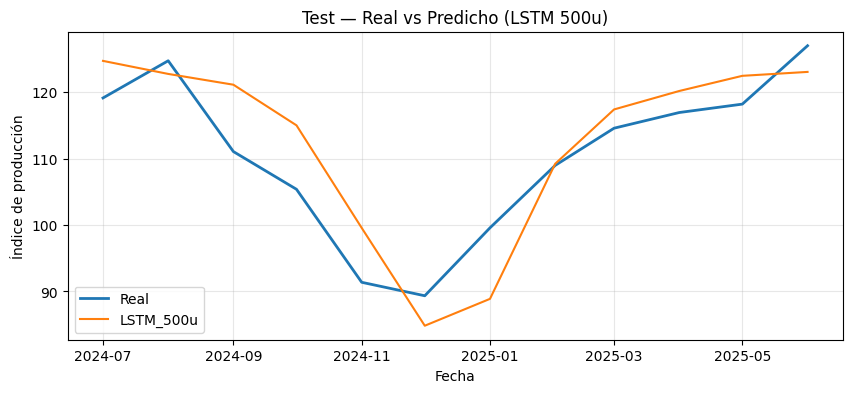

In [31]:
if "df_eval" in globals() and "LSTM_500u" in df_eval.columns:
    plt.figure(figsize=(10,4))
    plt.plot(df_eval.index, df_eval["y_real"],    label="Real", linewidth=2)
    plt.plot(df_eval.index, df_eval["LSTM_500u"], label="LSTM_500u")
    plt.title("Test — Real vs Predicho (LSTM 500u)")
    plt.xlabel("Fecha"); plt.ylabel("Índice de producción")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()
else:
    print("df_eval/LSTM_500u no disponible.")


In [18]:
best_name = df_metrics["RMSE"].idxmin()
best_rmse = float(df_metrics.loc[best_name, "RMSE"])
base_rmse = float(df_metrics.loc["Naive(prev)", "RMSE"])
mejora_pct = (base_rmse - best_rmse) / base_rmse * 100 if base_rmse > 0 else np.nan

print("== Resumen de evaluación ==")
print(f"- Mejor modelo por RMSE: {best_name} (RMSE={best_rmse:.3f}).")
print(f"- Baseline ingenuo (previo): RMSE={base_rmse:.3f}. Mejora relativa: {mejora_pct:.1f}%.")
print("- Si la validación muestra 'val_loss' estabilizada por encima de 'loss', considere:")
print("  • Aumentar `longitud_secuencia` (p. ej., 18–24) para capturar estacionalidad prolongada.")
print("  • Ajustar capacidad (pocos vs muchos units) y Dropout/L2 para evitar sobreajuste.")
print("  • Explorar stacked LSTM o un esquema walk-forward si se requiere horizonte >1 paso.")

== Resumen de evaluación ==
- Mejor modelo por RMSE: LSTM_50u (RMSE=6.280).
- Baseline ingenuo (previo): RMSE=8.882. Mejora relativa: 29.3%.
- Si la validación muestra 'val_loss' estabilizada por encima de 'loss', considere:
  • Aumentar `longitud_secuencia` (p. ej., 18–24) para capturar estacionalidad prolongada.
  • Ajustar capacidad (pocos vs muchos units) y Dropout/L2 para evitar sobreajuste.
  • Explorar stacked LSTM o un esquema walk-forward si se requiere horizonte >1 paso.


#### Test — Real vs Predicciones (gráfica conjunta)
- Todos los modelos reproducen la **forma en “U”** del tramo jul–may, pero **sobreestiman el valle** (nov–dic).
- **LSTM_50u** sigue mejor el **descenso sep–oct** y el **rebote**; 250/500u suavizan en exceso.
- Diferencias grandes se concentran en el **mínimo**; en la subida todos convergen.

##### Barras de RMSE
- **50u** es el mejor con el RMSE más bajo, y **500u** se le acerca; **100u** intermedio; **250u** el peor de los LSTM.
- Todos superan al **baseline ingenuo** de “valor previo”.

#### Test — Real vs Predicho por modelo
##### LSTM_50u
- Trayectoria **más cercana** al real en sep–oct y en el rebote de ene–mar.
- **Sesgo positivo** en el mínimo (sobreestima nov–dic), pero el **menor** entre modelos.

##### LSTM_100u
- **Sobreestima** de sep a dic con más intensidad; rebote algo **más suavizado**.
- Buenas pérdidas en validación, pero **sesgo**  en el valle.

##### LSTM_250u
- Mayor **suavizado** y retraso en la recuperación; errores más altos en el mínimo.
- **Sobreajuste** sin mejora de generalización.

##### LSTM_500u
- Combina buenas fases del rebote con **sobre/infraestimación** en el valle (nov–ene).
- Segundo mejor RMSE, pero **menos estable** que 50u.

#### Forecast FUTURO 

,LSTM_50u,LSTM_100u,LSTM_250u,LSTM_500u
2025-07-01,124.304008,122.617371,124.085861,121.785492
2025-08-01,120.527466,122.161194,124.062584,121.255165
2025-09-01,113.747391,119.792130,121.826057,118.484566
2025-10-01,108.386208,116.419212,118.275177,114.105522
2025-11-01,104.337234,110.539253,110.149376,104.708328
2025-12-01,103.899597,105.390289,102.238541,98.599052
2026-01-01,106.806419,104.822754,102.481125,101.455055
2026-02-01,111.249878,107.954514,106.980408,106.815285
2026-03-01,115.998573,112.238632,111.981720,112.041786
2026-04-01,120.272820,116.306473,116.717102,116.682381


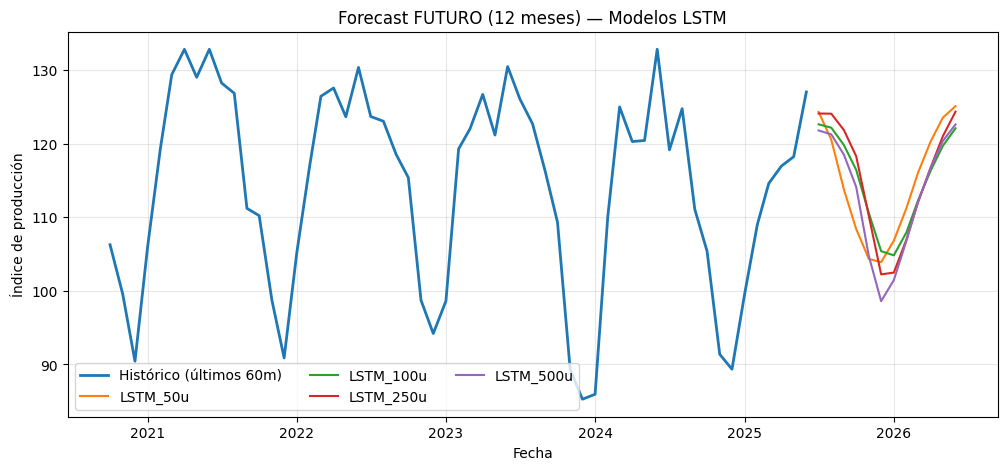

In [20]:
import numpy as np
import pandas as pd
from pandas.tseries import offsets

# Ventana final escalada (entrenamiento + prueba)
full_scaled = np.vstack([entrenamiento_escalado, prueba_escalada])
window_last = full_scaled[-longitud_secuencia:].reshape(1, longitud_secuencia, 1)

horizonte = 12
future_index = pd.date_range(serie.index[-1] + offsets.MonthBegin(1), periods=horizonte, freq="MS")

# --- 50u
future_50_scaled = []
w50 = window_last.copy()
if "model_50" in globals():
    for _ in range(horizonte):
        nxt = model_50.predict(w50, verbose=0)           # (1,1)
        future_50_scaled.append(nxt[0,0])
        w50 = np.concatenate([w50[:,1:,:], nxt.reshape(1,1,1)], axis=1)
    future_50 = scaler.inverse_transform(np.array(future_50_scaled).reshape(-1,1)).flatten()

# --- 100u
future_100_scaled = []
w100 = window_last.copy()
if "model_100" in globals():
    for _ in range(horizonte):
        nxt = model_100.predict(w100, verbose=0)
        future_100_scaled.append(nxt[0,0])
        w100 = np.concatenate([w100[:,1:,:], nxt.reshape(1,1,1)], axis=1)
    future_100 = scaler.inverse_transform(np.array(future_100_scaled).reshape(-1,1)).flatten()

# --- 250u (si existe)
future_250 = None
if "model_250" in globals():
    future_250_scaled = []
    w250 = window_last.copy()
    for _ in range(horizonte):
        nxt = model_250.predict(w250, verbose=0)
        future_250_scaled.append(nxt[0,0])
        w250 = np.concatenate([w250[:,1:,:], nxt.reshape(1,1,1)], axis=1)
    future_250 = scaler.inverse_transform(np.array(future_250_scaled).reshape(-1,1)).flatten()

# --- 500u (si existe)
future_500 = None
if "model_500" in globals():
    future_500_scaled = []
    w500 = window_last.copy()
    for _ in range(horizonte):
        nxt = model_500.predict(w500, verbose=0)
        future_500_scaled.append(nxt[0,0])
        w500 = np.concatenate([w500[:,1:,:], nxt.reshape(1,1,1)], axis=1)
    future_500 = scaler.inverse_transform(np.array(future_500_scaled).reshape(-1,1)).flatten()

# Construir DataFrame de forecast futuro (solo columnas disponibles)
cols_future = {}
if "model_50" in globals():  cols_future["LSTM_50u"]  = future_50
if "model_100" in globals(): cols_future["LSTM_100u"] = future_100
if "model_250" in globals(): cols_future["LSTM_250u"] = future_250
if "model_500" in globals(): cols_future["LSTM_500u"] = future_500

df_forecast_future = pd.DataFrame(cols_future, index=future_index)
display(df_forecast_future)

# Gráfica
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(serie.index[-60:], serie["produccion"].iloc[-60:], label="Histórico (últimos 60m)", linewidth=2)
for c in df_forecast_future.columns:
    plt.plot(df_forecast_future.index, df_forecast_future[c], label=c)
plt.title("Forecast FUTURO (12 meses) — Modelos LSTM")
plt.xlabel("Fecha"); plt.ylabel("Índice de producción")
plt.grid(True, alpha=0.3); plt.legend(ncol=3); plt.show()


- **Patrón**: los cuatro modelos mantienen la **estacionalidad**: descenso desde **jul–dic 2025**, mínimo en **dic–ene**, y recuperación durante el **1er semestre 2026**.
- **Rango entre modelos**:
  - **Jul-2025**: ~**121.8–124.3**.
  - **Dic-2025 (valle)**: ~**98.6–105.4** → el valle es **menos profundo que el histórico**, persistiendo la **sobreestimación**.
  - **Jun-2026 (pico)**: ~**122.1–125.1**.
- **Amplitud**:
  - **50u** proyecta el ciclo **más marcado** picos más altos.
  - **500u** muestra el **valle más profundo** y rebote más contenido.
  - **100u/250u** quedan como trayectorias **intermedias**.

  
Todos coinciden en la **fase** del ciclo; las diferencias están en la **amplitud**. Puede tomarse **50u** como senda central y el abanico **[mín, máx]** entre modelos como banda de incertidumbre.








#### 1) Datos y estructura
- Serie mensual **IPN31152N** producción de helados/postres. **57 observaciones** , **sin NaNs** ni duplicados; frecuencia  consistente.  
- Estacionalidad marcada: picos a mitad de año y **valle en nov-dic**; tendencia suave y ciclos anuales claros.

#### 2) Split y preparación
- **Prueba = 24 meses** finales sin fuga temporal.  
- **MinMaxScaler** ajustado en **train** y aplicado a **test**.  
- Generadores con `length=12`, `stride=1`, `sampling_rate=1`, `shuffle=False` → **ventanas**: train≈14, val≈7, test≈12.  
- Con  pocos ejemplos efectivos, la varianza del estimador aumenta y los modelos grandes tienden a memorizar.

#### 3) Modelado y entrenamiento
- Arquitectura **stl**: `LSTM(units) → Dropout(0.2) → Dense(1, L2=1e-4)`, Adam(1e-3), MSE/MAE; callbacks (**EarlyStopping**, **ReduceLROnPlateau**).  
- Curvas de pérdida: todos descienden rápido y luego se estabilizan.  
  - **50u**: val_loss estable pero más alta con capacidad justa presenta un leveunderfitting.  
  - **100u**: menor val_loss en entrenamiento train–val.  
  - **250u/500u**: train cae más que val pero muestra señales de sobreajuste y mayor costo.

#### 4) Resultados 
- **Ranking por RMSE**: **50u (6.28)** < **500u (6.35)** < 100u (6.73) < 250u (7.93) < **Naive(prev) (8.88)**.  
- **Mejora vs Naive**: 50u ≈ **29%**, 500u ≈ 29%, 100u ≈ 24%, 250u ≈ 11%.  
- **MAE/MAPE** corroboran: **50u** es el más parsimonioso y preciso; 500u queda muy cerca pero con menor estabilidad.

#### 5) Comportamiento por tramo (jul–nov 2024)
- Todos los modelos sobreestiman el valle , con real ≈ **91** en nov frente a **99–106** predicho.  
- En este periodo, **50u** logra el MAE más bajo; 250/500u suavizan en exceso y rellenan el mínimo.

#### 6) Forecast FUTURO (12 meses)
- Los cuatro preservan la fase estacional .  
- Diferencias en amplitud:  
  - **50u** proyecta el ciclo más marcado .  
  - **500u** da el valle más profundo y rebote más contenido.  
- El valle futuro sigue menos profundo que el histórico persiste el sesgo positivo en mínimos.

#### 7) Diagnóstico del error
- Causa principal del sesgo: **información estacional insuficiente** para modelar caídas abruptas.  
- La muestra pequeña  limita la generalización yla validación  es frágil como criterio de selección.  
- El escalado MinMax sobre train puede atenuar extremos si el test rompe rangos como consecuencia los modelos grandes tienden a suavizar.

#### 8) Conclusión técnica
- Para este dataset, el*mejor compromiso precisión-estabilidad-costo es **LSTM_50u**; **100u** es competitivo pero con mayor sesgo en el valle; **250/500u** no justifican su complejidad.  
- Todos superan un baseline ingenuo t-1, pero sería pertinente comparar también con un baseline estacional t-12 dada la estacionalidad fuerte.

